In [1]:
import warnings
warnings.filterwarnings('ignore')

In [2]:
import matplotlib.pyplot as plt
import numpy as np
import os
import PIL
from PIL import Image
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.callbacks import Callback
import random 
from tensorflow.keras import layers
from tensorflow.python.keras.layers import Dense, Flatten
from tensorflow.keras.models import Sequential
from tensorflow.keras.optimizers import Adam
from sklearn.metrics import confusion_matrix
import seaborn as sns 
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from keras.applications.resnet50 import ResNet50 
from keras.applications.resnet50 import preprocess_input
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.regularizers import l2
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau


2024-08-29 22:17:58.011796: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2024-08-29 22:17:58.023360: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:485] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-08-29 22:17:58.035232: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:8454] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-08-29 22:17:58.038427: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1452] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-08-29 22:17:58.047789: I tensorflow/core/platform/cpu_feature_guar

In [3]:
seed_value = 42
random.seed(seed_value)  # Python
np.random.seed(seed_value)  # NumPy
tf.random.set_seed(seed_value)  # TensorFlow

In [4]:
log_dir = '/mnt/c/Users/Rahul/Desktop/Document-and-Record-Management/notebooks/experiments/'

In [5]:
train_dir = "/mnt/c/Users/Rahul/Desktop/datasets/forclassification/train/"
val_dir = "/mnt/c/Users/Rahul/Desktop/datasets/forclassification/val/"

In [6]:
batch_size = 8
img_height, img_width = 500 , 500

In [7]:
train_datagen = ImageDataGenerator(
    preprocessing_function=preprocess_input,
    rotation_range=3,         
    width_shift_range=0.1,     
    height_shift_range=0.1,   
    zoom_range=0.2,         
    brightness_range=[0.8, 1.2],
    shear_range=0.2,      
    horizontal_flip=False,
    vertical_flip=False
)

val_datagen = ImageDataGenerator(
    preprocessing_function=preprocess_input
)


In [8]:
train_ds = train_datagen.flow_from_directory(
    train_dir,
    target_size=(img_height, img_width),
    batch_size=batch_size,
    class_mode='categorical',
    shuffle=True
    )

Found 900 images belonging to 4 classes.


In [9]:
val_ds = train_datagen.flow_from_directory(
    val_dir,
    target_size=(img_height, img_width),
    batch_size=batch_size,
    class_mode='categorical',
    shuffle=False
    )

Found 213 images belonging to 4 classes.


In [10]:
train_ds.image_shape

(500, 500, 3)

In [11]:
num_classes = 4

In [12]:
resnet= tf.keras.applications.ResNet50(include_top=False,
                   input_shape=(img_height,img_width,3),
                   pooling='avg',
                   weights='imagenet')
for layer in resnet.layers:
        layer.trainable=False


I0000 00:00:1724949180.529996   80549 cuda_executor.cc:1001] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
I0000 00:00:1724949180.699636   80549 cuda_executor.cc:1001] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
I0000 00:00:1724949180.699712   80549 cuda_executor.cc:1001] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
I0000 00:00:1724949180.702404   80549 cuda_executor.cc:1001] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
I0000 00:00:1724949180.702470   80549 cuda_executor.cc:1001] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
I0000 00:0

In [13]:
# Determine 70% of the layers
num_layers_to_freeze = int(0.70* len(resnet.layers))

# Freeze the first 70% of layers
for i, layer in enumerate(resnet.layers):
    if i < num_layers_to_freeze:
        layer.trainable = False

In [14]:
model = Sequential([ 
    resnet,
    layers.Flatten(), 
    layers.Dense(448, activation='relu',kernel_regularizer=l2(1e-5)),
    layers.Dense(240, activation='relu',kernel_regularizer=l2(1e-5)),
    layers.Dense(112, activation='relu',kernel_regularizer=l2(1e-5)),
    layers.Dropout(0.3), 
    layers.Dense(num_classes, activation='softmax')])

In [15]:
model.summary() 

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ resnet50 (Functional)           │ (None, 2048)           │    23,587,712 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 2048)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 448)            │       917,952 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 240)            │       107,760 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 112)            │        26,992 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 112)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 4)              │           452 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 24,640,868 (94.00 MB)

 Trainable params: 1,053,156 (4.02 MB)

 Non-trainable params: 23,587,712 (89.98 MB)

In [16]:
model.compile(optimizer=Adam(learning_rate=4e-4),
              loss="categorical_crossentropy",
              metrics=["accuracy"] 
             )

early_stopping = EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)


In [17]:
lr_scheduler = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=2, min_lr=1e-6)

In [18]:
history = model.fit(
  train_ds,
  validation_data=val_ds,
  epochs=10,
  callbacks=[early_stopping,lr_scheduler] 
  )

Epoch 1/10


I0000 00:00:1724949191.103133   80846 service.cc:146] XLA service 0x7f0a00001e50 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1724949191.103186   80846 service.cc:154]   StreamExecutor device (0): NVIDIA GeForce RTX 4060 Laptop GPU, Compute Capability 8.9
2024-08-29 22:18:11.268830: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:268] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
2024-08-29 22:18:12.137833: I external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:531] Loaded cuDNN version 8907


  1/113 ━━━━━━━━━━━━━━━━━━━━ 29:17 16s/step - accuracy: 0.1250 - loss: 1.8735

I0000 00:00:1724949200.158302   80846 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


113/113 ━━━━━━━━━━━━━━━━━━━━ 71s 497ms/step - accuracy: 0.6255 - loss: 0.8660 - val_accuracy: 0.9671 - val_loss: 0.1285 - learning_rate: 4.0000e-04
Epoch 2/10
113/113 ━━━━━━━━━━━━━━━━━━━━ 42s 355ms/step - accuracy: 0.9638 - loss: 0.1657 - val_accuracy: 0.9484 - val_loss: 0.1247 - learning_rate: 4.0000e-04
Epoch 3/10
113/113 ━━━━━━━━━━━━━━━━━━━━ 42s 351ms/step - accuracy: 0.9687 - loss: 0.1099 - val_accuracy: 0.9671 - val_loss: 0.1158 - learning_rate: 4.0000e-04
Epoch 4/10
113/113 ━━━━━━━━━━━━━━━━━━━━ 42s 354ms/step - accuracy: 0.9967 - loss: 0.0524 - val_accuracy: 0.9531 - val_loss: 0.1609 - learning_rate: 4.0000e-04
Epoch 5/10
113/113 ━━━━━━━━━━━━━━━━━━━━ 42s 352ms/step - accuracy: 0.9798 - loss: 0.0784 - val_accuracy: 0.9765 - val_loss: 0.1052 - learning_rate: 4.0000e-04
Epoch 6/10
113/113 ━━━━━━━━━━━━━━━━━━━━ 42s 351ms/step - accuracy: 0.9859 - loss: 0.0654 - val_accuracy: 0.9671 - val_loss: 0.1138 - learning_rate: 4.0000e-04
Epoch 7/10
113/113 ━━━━━━━━━━━━━━━━━━━━ 42s 349ms/step - 

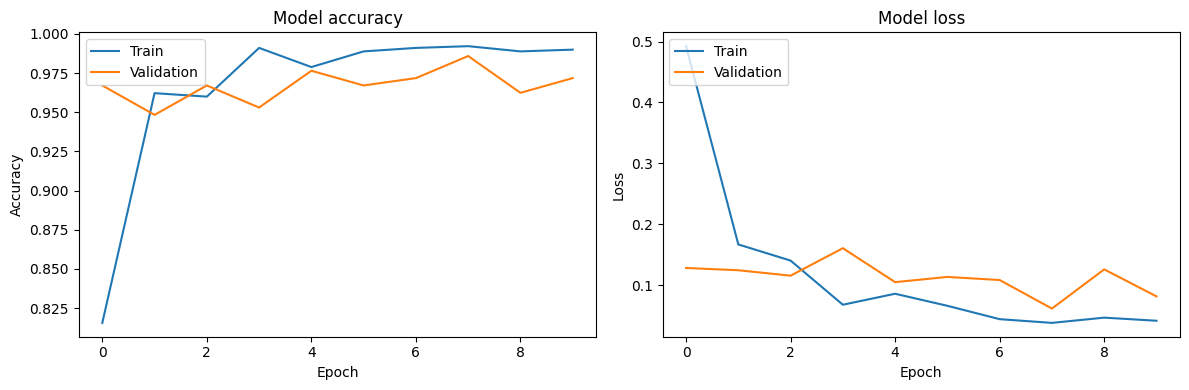

In [21]:
# Plot training & validation accuracy values
plt.figure(figsize=(12, 4))

plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')

# Plot training & validation loss values
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')

plt.tight_layout()
plt.show()

In [20]:
model.save("performed well.h5")